In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini")

In [16]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the review")

In [17]:
class DiagnosticSchema(BaseModel):
    issue_type: Literal["bug", "performance", "design", "other"] = Field(description="The type of issue in the review")
    tone: Literal["angry", "frustrated", "calm", "disappointed"] = Field(description="The tone of the review")
    urgency: Literal["low", "medium", "high"] = Field(description="The urgency of the issue")
    

In [18]:
structured_model_1 = model.with_structured_output(SentimentSchema)
structured_model_2 = model.with_structured_output(DiagnosticSchema)

In [19]:
prompt = "The software seems fine but not too good"
structured_model_1.invoke(prompt)

e:\FastApi\myenv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=SentimentSchema(sentiment='negative'), input_type=SentimentSchema])
  return self.__pydantic_serializer__.to_python(


SentimentSchema(sentiment='negative')

In [20]:
class ReviewReplyState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    dianosis: dict
    response: str

In [42]:
def find_sentiment(state: ReviewReplyState):
    prompt = f"""
    Given the following review, please determine the sentiment of the review.
    Review: {state["review"]}
    """
    response = structured_model_1.invoke(prompt)
    return {"sentiment": response.sentiment}

def positive_response(state: ReviewReplyState):
    prompt = f"""
    Write a warm thank you message in response to the following review.
    Review: {state["review"]}
    Also, kindly ask user to leave feedback on website
    """
    response = model.invoke(prompt)
    return {"response": response.content}

def run_diagnostic(state: ReviewReplyState):
    prompt = f"""
    Given the following review,
    Review: {state["review"]}
    return issue_type, tone, urgency
    """
    response = structured_model_2.invoke(prompt)
    return {"dianosis": response.model_dump()}

def negative_response(state: ReviewReplyState):
    prompt = f""" 
    You are a customer support agent.
    The user had a '{state["dianosis"]["issue_type"]}' issue.
    The tone of the review is '{state["dianosis"]["tone"]}'
    The urgency of the issue is '{state["dianosis"]["urgency"]}'
    Write a response to the user's review.
    Review: {state["review"]}
    """
    response = model.invoke(prompt)
    return {"response": response.content}

def check_sentiment(state: ReviewReplyState) -> Literal["positive_response", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"




In [43]:
graph = StateGraph(ReviewReplyState)

graph.add_node("find_Sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnostic)
graph.add_node("negative_response", negative_response)


graph.add_edge(START, "find_Sentiment")
graph.add_conditional_edges("find_Sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()



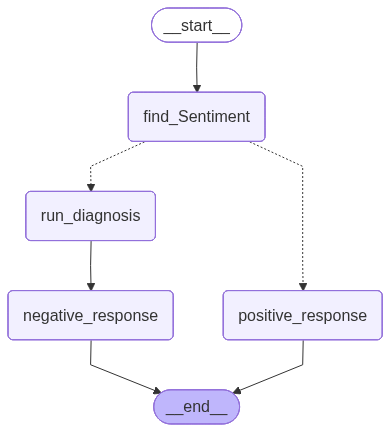

In [44]:
workflow

In [45]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'dianosis': {'issue_type': 'bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Dear [User's Name],\n\nThank you for reaching out and sharing your experience with us. I sincerely apologize for the frustration you've encountered while trying to log in and appreciate your patience as we work to resolve this issue.\n\nI understand how critical it is for you to access the app, especially when it's not functioning as expected. Your feedback regarding the freezing on the authentication screen is important, and I assure you that we are taking this matter seriously.\n\nIn the meantime, I recommend trying the following troubleshooting steps, if you haven't already:\n1. Clear the app cache from your device settings.\n2